In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Set up directory paths
base_dir = '/content/drive/MyDrive/AI/Skin Cancer/Skin Cancer'
img_path = '/content/drive/MyDrive/AI/Skin Cancer/Skin Cancer/combined_images'
metadata_file = '/content/drive/MyDrive/AI/HAM10000_metadata.csv'
labels_csv='/content/drive/MyDrive/AI/final_labels_df.csv'

In [7]:
labels_df = pd.read_csv(labels_csv)
image_paths = labels_df['image_id'].values
string_labels = labels_df['dx'].values

# Combine the directory path with the filenames
image_paths = [os.path.join(img_path, filename) for filename in image_paths]

In [8]:
# Map string labels to integers
label_mapping = {'not melanoma': 0, 'melanoma': 1}
numeric_labels = np.array([label_mapping[label] for label in string_labels])

# Encode labels to one-hot vectors
labels = to_categorical(numeric_labels, num_classes=2)

In [9]:
# Split data into training and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Parameters
img_height, img_width = 224, 224
batch_size = 32


In [10]:
# Function to load and preprocess images
def load_and_preprocess_image(img_path):
    if not os.path.exists(img_path):
        print(f"File not found: {img_path}")
    img = load_img(img_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = tf.keras.applications.densenet.preprocess_input(img)
    return img


In [11]:
def generator(image_paths, labels, batch_size):
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_paths = image_paths[start:end]
            batch_labels = labels[start:end]
            batch_images = np.array([load_and_preprocess_image(img_path) for img_path in batch_paths])
            yield batch_images, batch_labels

In [12]:
train_generator = generator(train_paths, train_labels, batch_size)
test_generator = generator(test_paths, test_labels, batch_size)

In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


In [ ]:
# Freeze the layers except the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [ ]:
# Add custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)  # L2 regularization
predictions = Dense(2, activation='softmax')(x)

In [ ]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
#Compile the model

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
# Train the model
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

In [ ]:
model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=test_generator,
    validation_steps=validation_steps
)


# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=validation_steps)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')
# Save the entire model to a file
model.save('/content/drive/MyDrive/AI/Skin Cancer/densenet121_melanoma_classifier.keras')


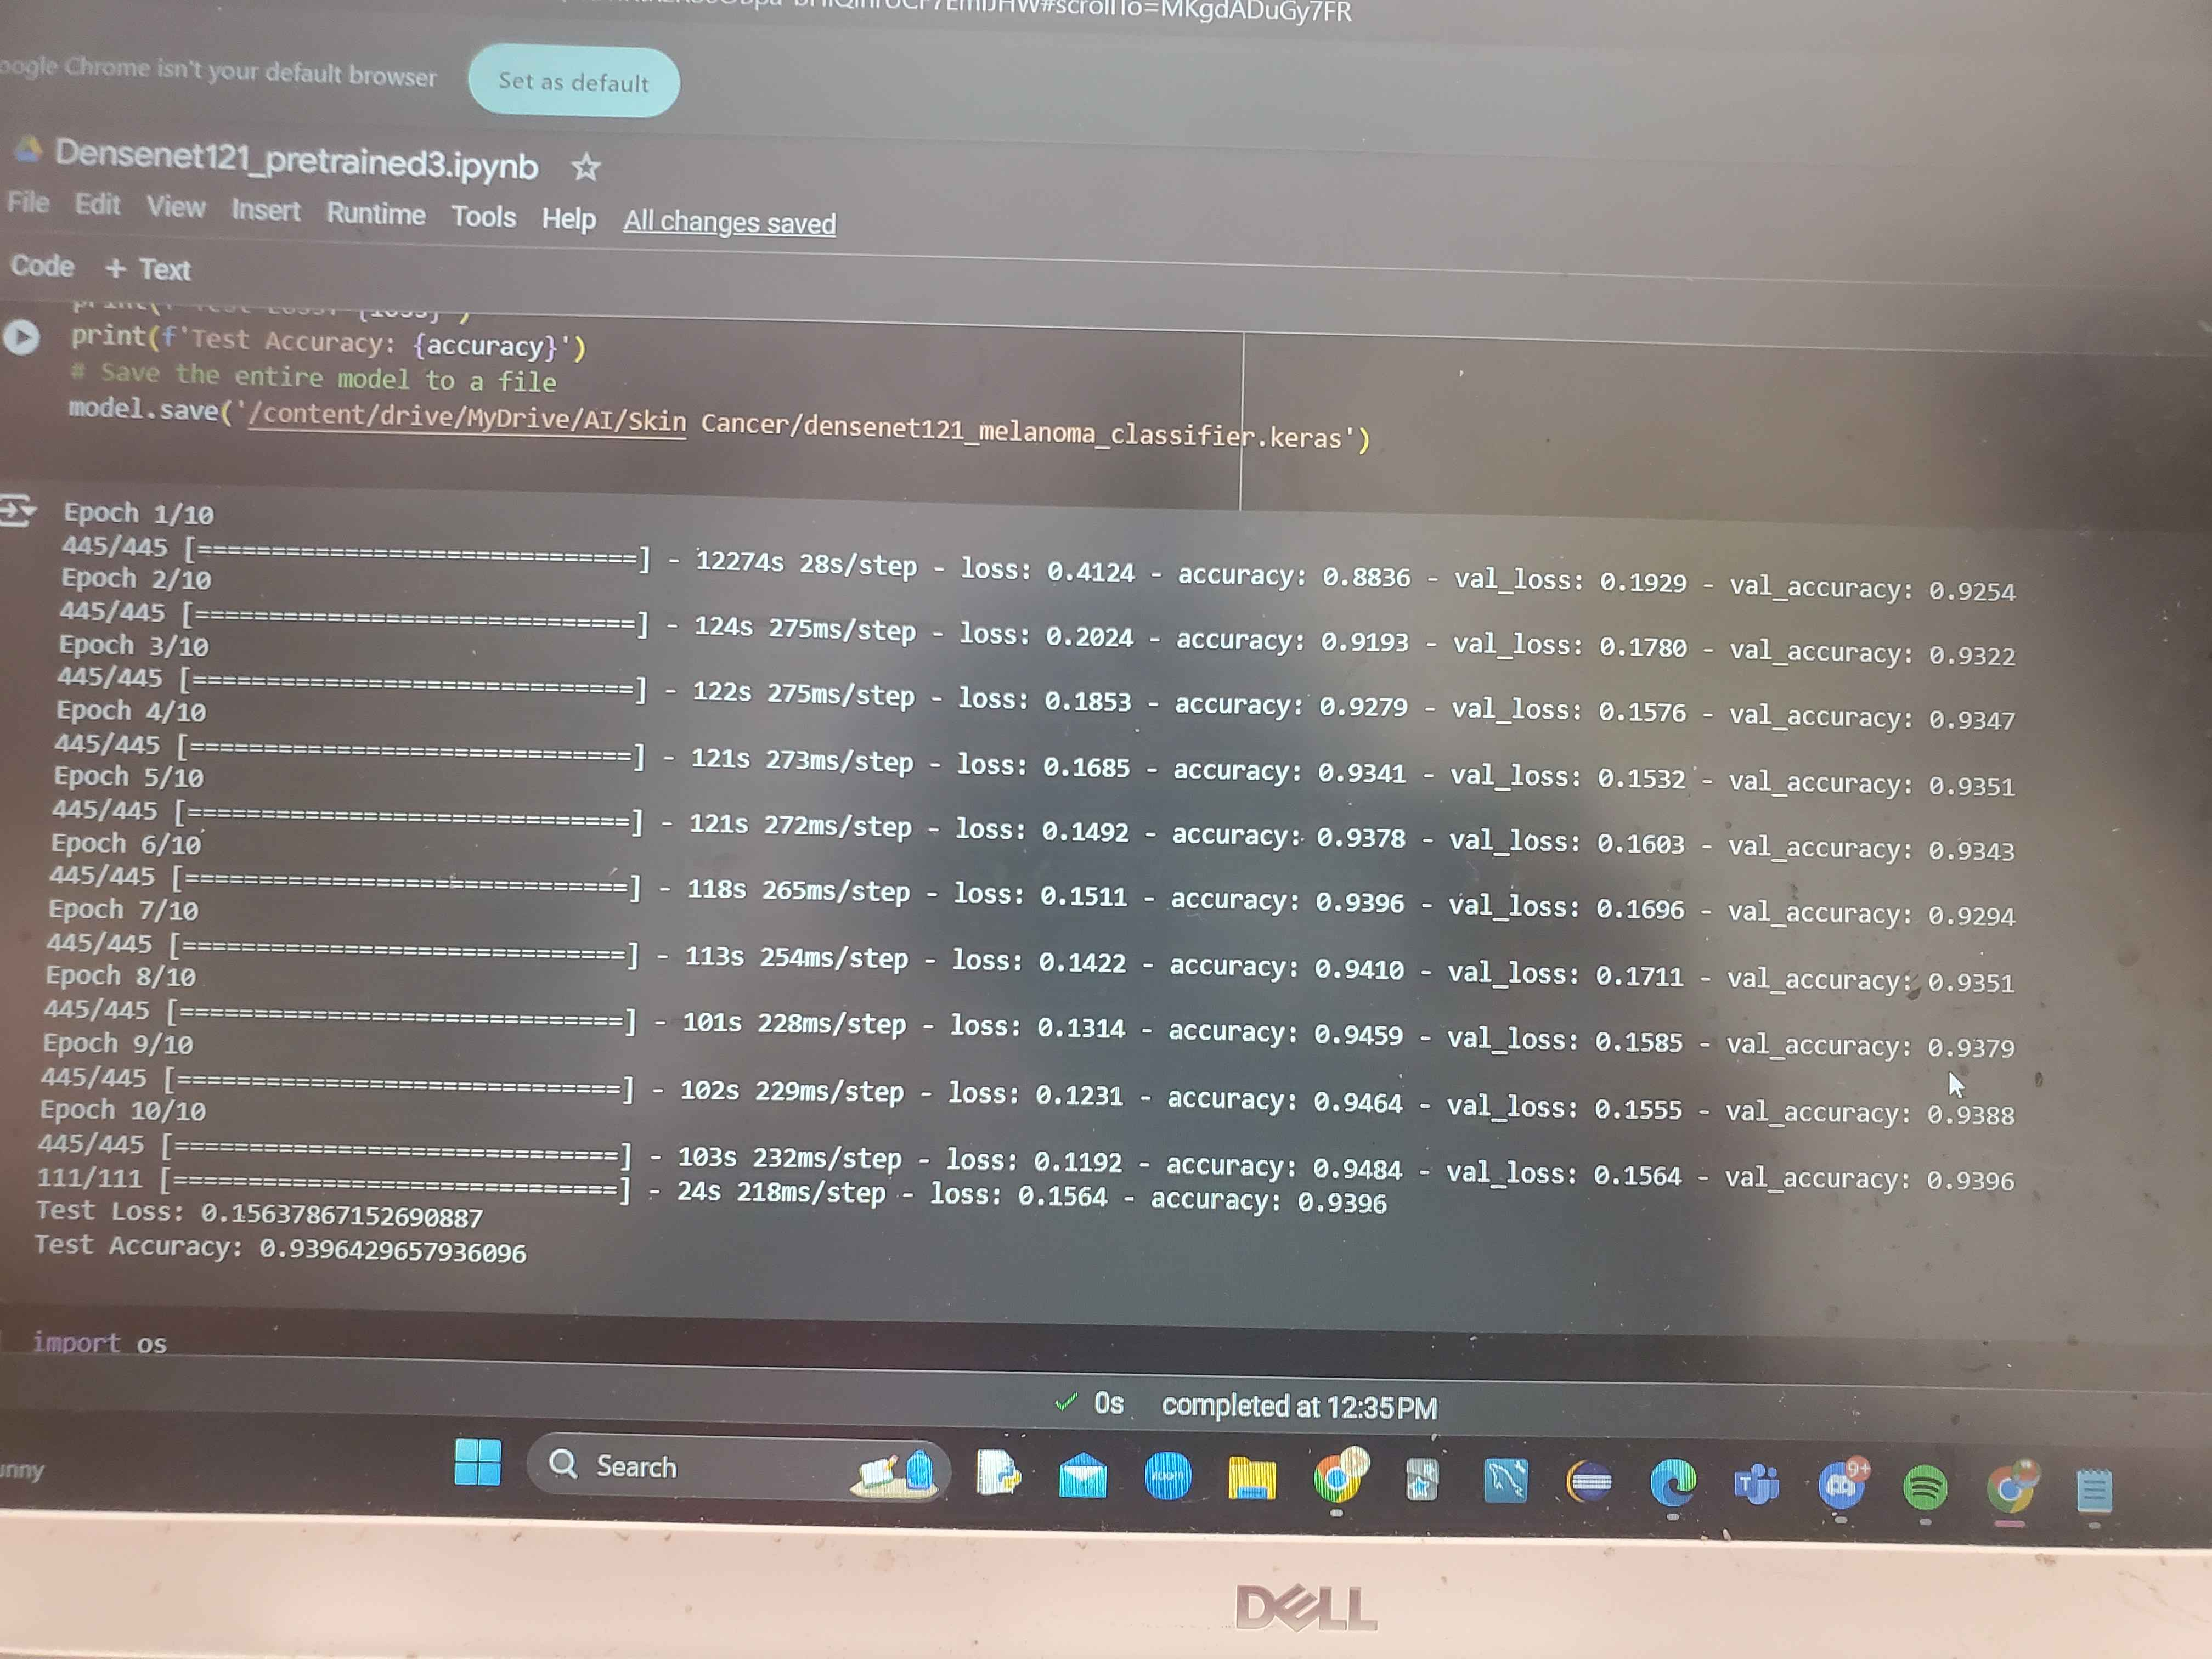

In [ ]:
#These were the values obtained after training the model. I forgot to save model.fit to a variable, so I just used the displayed training values to make the curve
#The values were lost after I accidently ran the training code again but please be assured that they accurately reflect the results of my model
#I have attached a previous image of the training data as proof

# Manually extracted values
epochs = list(range(1, 11))  # 10 epochs

# Accuracy values
accuracy = [0.8836, 0.9193, 0.9279, 0.9341, 0.9378, 0.9396, 0.9410, 0.9459, 0.9464, 0.9484]
val_accuracy = [0.9254, 0.9322, 0.9347, 0.9351, 0.9343, 0.9294, 0.9351, 0.9379, 0.9388, 0.9396]

# Loss values
loss = [0.4124, 0.2024, 0.1853, 0.1685, 0.1492, 0.1511, 0.1422, 0.1314, 0.1231, 0.1192]
val_loss = [0.1929, 0.1780, 0.1576, 0.1532, 0.1603, 0.1696, 0.1711, 0.1585, 0.1555, 0.1564]

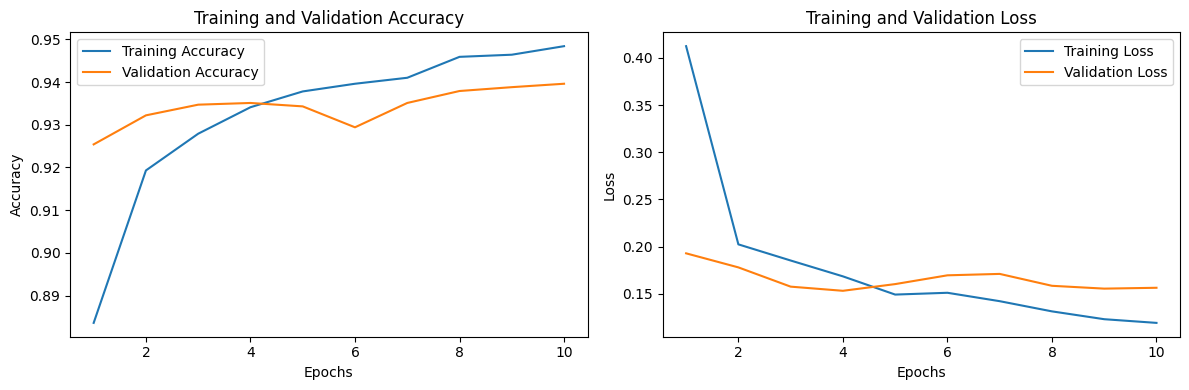

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
loaded_model = load_model('/content/drive/MyDrive/AI/Skin Cancer/densenet121_melanoma_classifier.keras')


predictions = loaded_model.predict(test_generator, steps = 112)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 738 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


112/112 ━━━━━━━━━━━━━━━━━━━━ 2504s 23s/step


In [14]:

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)
convert = lambda x : 1 if x[1] == 1. else 0
test_labelsconf = list(map(convert, test_labels))

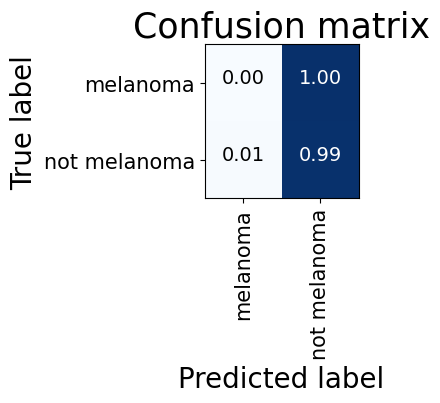

In [15]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(actual, predicted):

    cm = confusion_matrix(actual, predicted)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(2,2))
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix', fontsize=25)

    tick_marks = np.arange(2)
    classes = ['melanoma', 'not melanoma']
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.show()
# Convert to a NumPy array
plot_confusion_matrix(test_labelsconf, predicted_classes)

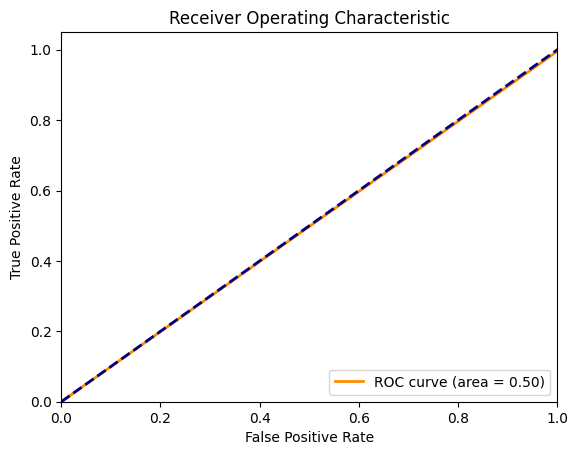

In [18]:
#AUC and AUROC
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC Curve and AUC
fpr, tpr, _ = roc_curve(test_labelsconf, predicted_classes)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
